处理数据

In [2]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pickle
import spektral
from spektral.layers import GCNConv, GATConv
from spektral.models.gcn import GCN
from spektral.data import Graph
from spektral.data.loaders import SingleLoader

# 检查GPU并启用内存增长
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"已检测到GPU: {physical_devices}")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("已启用GPU内存动态增长")
else:
    print("未检测到GPU，将使用CPU")

# 设置路径
WIKI_DIR = "./wiki"
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

# 1. 加载三元组数据
print("加载知识图谱数据...")

def load_triples(file_path):
    try:
        df = pd.read_csv(file_path, sep='\t', header=None, 
                         names=['head', 'relation', 'tail'])
        print(f"从 {file_path} 加载了 {len(df)} 个三元组")
        return df
    except Exception as e:
        print(f"无法加载 {file_path}: {e}")
        return pd.DataFrame(columns=['head', 'relation', 'tail'])

train_df = load_triples(os.path.join(WIKI_DIR, 'train.txt'))
test_df = load_triples(os.path.join(WIKI_DIR, 'test.txt'))
valid_df = load_triples(os.path.join(WIKI_DIR, 'valid.txt'))

# 2. 从训练集、验证集和测试集中提取所有实体和关系
print("\n从训练集、验证集和测试集中提取实体和关系ID...")
all_dataset_entities = pd.concat([
    train_df['head'], train_df['tail'],
    valid_df['head'] if not valid_df.empty else pd.Series(),
    valid_df['tail'] if not valid_df.empty else pd.Series(), 
    test_df['head'] if not test_df.empty else pd.Series(),
    test_df['tail'] if not test_df.empty else pd.Series()
]).unique().tolist()

all_dataset_relations = pd.concat([
    train_df['relation'],
    valid_df['relation'] if not valid_df.empty else pd.Series(),
    test_df['relation'] if not test_df.empty else pd.Series()
]).unique().tolist()

print(f"从所有数据集中提取了 {len(all_dataset_entities)} 个实体和 {len(all_dataset_relations)} 个关系")

# 3. 加载实体和关系数据，并确保三元组中的所有ID都包含
print("\n加载实体和关系（带别名）...")

def load_entities_with_aliases(file_path, all_ids_from_triples):
    """加载实体或关系文件，保留ID和所有别名，并确保包含三元组中的所有ID"""
    id_to_aliases = {}
    aliases_to_id = {}
    all_ids = set()
    
    # 首先尝试从文件加载
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 1:
                    continue
                
                entity_id = parts[0]
                aliases = parts[1:] if len(parts) > 1 else [entity_id]
                
                # 添加ID作为默认别名
                if entity_id not in aliases:
                    aliases.append(entity_id)
                
                id_to_aliases[entity_id] = aliases
                all_ids.add(entity_id)
                
                # 为每个别名创建反向映射
                for alias in aliases:
                    aliases_to_id[alias] = entity_id
        
        print(f"从 {file_path} 加载了 {len(id_to_aliases)} 个ID，共 {len(aliases_to_id)} 个别名")
    except Exception as e:
        print(f"无法从文件加载别名: {e}")
    
    # 确保包含三元组中的所有ID
    missing_ids = set(all_ids_from_triples) - all_ids
    if missing_ids:
        print(f"发现 {len(missing_ids)} 个在三元组中出现但文件中不存在的ID")
        for entity_id in missing_ids:
            id_to_aliases[entity_id] = [entity_id]
            aliases_to_id[entity_id] = entity_id
            all_ids.add(entity_id)
    
    print(f"最终包含了 {len(id_to_aliases)} 个ID")
    return id_to_aliases, aliases_to_id, list(id_to_aliases.keys())

# 加载实体和关系文件
entity_file = os.path.join(WIKI_DIR, 'entity.txt')
relation_file = os.path.join(WIKI_DIR, 'relation.txt')

entity_id_to_aliases, entity_alias_to_id, entity_ids = load_entities_with_aliases(
    entity_file, all_dataset_entities
)

relation_id_to_aliases, relation_alias_to_id, relation_ids = load_entities_with_aliases(
    relation_file, all_dataset_relations
)

# 4. 编码实体和关系
print("\n准备编码器...")
entity_encoder = LabelEncoder()
relation_encoder = LabelEncoder()

entity_encoder.fit(entity_ids)
relation_encoder.fit(relation_ids)


已检测到GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
已启用GPU内存动态增长
加载知识图谱数据...
从 ./wiki\train.txt 加载了 20614279 个三元组
从 ./wiki\test.txt 加载了 5133 个三元组
从 ./wiki\valid.txt 加载了 5163 个三元组

从训练集、验证集和测试集中提取实体和关系ID...
从所有数据集中提取了 4594485 个实体和 822 个关系

加载实体和关系（带别名）...
从 ./wiki\entity.txt 加载了 4813491 个ID，共 28835154 个别名
发现 4844 个在三元组中出现但文件中不存在的ID
最终包含了 4818335 个ID
从 ./wiki\relation.txt 加载了 825 个ID，共 4232 个别名
发现 3 个在三元组中出现但文件中不存在的ID
最终包含了 828 个ID

准备编码器...


LabelEncoder()

建立图结构

In [16]:
# 5. 构建图结构 (适用于Spektral)
print("\n构建图结构...")
num_entities = len(entity_encoder.classes_)
num_relations = len(relation_encoder.classes_)

print(f"实体数量: {num_entities}, 关系数量: {num_relations}")

# 准备节点特征 (结合随机和位置编码)
print("初始化增强的节点特征...")
feature_dim = 32  # 增加到32维，提供更丰富的表示能力

# 使用更复杂的节点特征初始化 - 结合位置编码
node_features = np.zeros((num_entities, feature_dim))
for i in range(num_entities):
    # 半随机半结构化特征
    for j in range(feature_dim):
        if j % 2 == 0:
            # 位置编码：基于实体ID的正弦编码
            node_features[i, j] = np.sin(i / (10000 ** (j / feature_dim)))
        else:
            # 位置编码：基于实体ID的余弦编码
            node_features[i, j] = np.cos(i / (10000 ** ((j-1) / feature_dim)))
    
    # 添加少量噪声以增加多样性
    node_features[i] += np.random.normal(0, 0.1, feature_dim)




构建图结构...
实体数量: 4818335, 关系数量: 828
初始化增强的节点特征...


In [20]:
# 创建邻接矩阵
print("创建邻接矩阵...")
edges_src = entity_encoder.transform(train_df['head'])
edges_dst = entity_encoder.transform(train_df['tail'])
edge_types = relation_encoder.transform(train_df['relation'])

# 定义最大节点数
max_nodes = 500000  # 最大采样50万个节点

# 替换原随机采样代码，使用顺序采样或优先采样策略
if num_entities <= max_nodes:
    # 如果实体数不超过最大节点数，直接使用所有实体
    sampled_indices = np.arange(num_entities)
    print(f"使用全部 {num_entities} 个实体，无需采样")
else:
    # 优先包含验证集和测试集的实体
    priority_entities = set()
    
    # 收集验证集和测试集的实体
    for df in [valid_df, test_df]:
        if not df.empty:
            for _, row in df.iterrows():
                if row['head'] in entity_alias_to_id:
                    priority_entities.add(entity_alias_to_id[row['head']])
                if row['tail'] in entity_alias_to_id:
                    priority_entities.add(entity_alias_to_id[row['tail']])
    
    # 转换为索引
    priority_indices = []
    for entity_id in priority_entities:
        if entity_id in entity_encoder.classes_:
            idx = np.where(entity_encoder.classes_ == entity_id)[0][0]
            priority_indices.append(idx)
    
    priority_indices = np.array(priority_indices)
    
    # 随机采样剩余的实体
    remaining_count = max_nodes - len(priority_indices)
    if remaining_count > 0:
        # 获取未优先的索引
        all_indices = np.arange(num_entities)
        mask = np.ones(num_entities, dtype=bool)
        mask[priority_indices] = False
        remaining_indices = all_indices[mask]
        
        # 随机采样剩余索引
        sampled_remaining = np.random.choice(
            remaining_indices, 
            min(remaining_count, len(remaining_indices)), 
            replace=False
        )
        
        # 合并优先索引和随机采样的索引
        sampled_indices = np.concatenate([priority_indices, sampled_remaining])
    else:
        # 如果优先实体已经超过最大节点数，只使用优先实体
        sampled_indices = np.random.choice(priority_indices, max_nodes, replace=False)
    
    print(f"优先包含了 {len(priority_indices)} 个验证/测试实体, 总采样 {len(sampled_indices)} 个实体")

# 提取采样节点的特征
node_features = node_features[sampled_indices]

# 创建索引映射字典
idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sampled_indices)}

# 过滤只包含采样节点的边
mask_src = np.isin(edges_src, sampled_indices)
mask_dst = np.isin(edges_dst, sampled_indices)
mask = mask_src & mask_dst

edges_src_filtered = edges_src[mask]
edges_dst_filtered = edges_dst[mask]
edge_types_filtered = edge_types[mask]

# 重映射节点索引
edges_src_mapped = np.array([idx_map[idx] for idx in edges_src_filtered])
edges_dst_mapped = np.array([idx_map[idx] for idx in edges_dst_filtered])

print(f"过滤后的边数量: {len(edges_src_mapped)} (原始: {len(edges_src)})")

# 使用scipy创建稀疏邻接矩阵
from scipy.sparse import csr_matrix
import scipy.sparse as sp

# 创建稀疏邻接矩阵
data = np.ones(len(edges_src_mapped))
adj = sp.coo_matrix((data, (edges_src_mapped, edges_dst_mapped)), 
                   shape=(len(sampled_indices), len(sampled_indices)))
adj = adj.tocsr()  # 转换为CSR格式提高性能

# 更新实体数
num_entities = len(sampled_indices)
print(f"采样后图的节点数: {num_entities}, 边数: {len(edges_src_mapped)}")

# 更新训练用边的信息
edges_src = edges_src_mapped
edges_dst = edges_dst_mapped
edge_types = edge_types_filtered

# 将SciPy稀疏矩阵转换为TensorFlow稀疏张量
def scipy_sparse_to_tf_sparse(sparse_mx):
    """将scipy稀疏矩阵转换为tensorflow稀疏张量，确保索引正确排序"""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    
    # 获取行列索引和值
    indices = np.column_stack((sparse_mx.row, sparse_mx.col))
    values = sparse_mx.data
    shape = sparse_mx.shape
    
    # 对索引进行排序
    sorted_idx = np.lexsort((indices[:, 1], indices[:, 0]))
    indices = indices[sorted_idx]
    values = values[sorted_idx]
    
    # 创建TensorFlow稀疏张量
    return tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=shape)

# 转换邻接矩阵为TensorFlow稀疏张量
adj_tensor = scipy_sparse_to_tf_sparse(adj)

创建邻接矩阵...
优先包含了 15417 个验证/测试实体, 总采样 500000 个实体
过滤后的边数量: 1330947 (原始: 20614279)
采样后图的节点数: 500000, 边数: 1330947


创建模型

In [27]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Dense, Dropout, Layer

# 6. 创建标准GNN模型
print("\n创建标准GNN模型...")

# 导入必要的层
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Reshape, Concatenate
from spektral.layers import GCNConv

# 用于调试的形状打印函数
def print_shape(name, tensor):
    if isinstance(tensor, tf.SparseTensor):
        print(f"{name} 形状: 稀疏张量 {tensor.dense_shape}")
    else:
        print(f"{name} 形状: {tf.shape(tensor)}")

# 自定义多关系卷积层 (简化版)
class MyRelationalConv(Layer):
    def __init__(self, hidden_dim, num_relations, **kwargs):
        super().__init__(**kwargs)
        self.num_relations = num_relations
        self.hidden_dim = hidden_dim
        # 为每种关系单独的权重矩阵 W_r
        self.relation_weights = []
        for r in range(num_relations):
            w = self.add_weight(
                shape=(hidden_dim, hidden_dim),
                initializer='glorot_uniform',
                trainable=True,
                name=f"W_rel{r}"
            )
            self.relation_weights.append(w)

    def call(self, inputs):
        """
        inputs = [x] + [adj_r0, adj_r1, ..., adj_r{num_relations-1}]
        x: (N, hidden_dim)
        adj_rk: (N, N), sparse or dense
        """
        x = inputs[0]
        adjs = inputs[1:]  # list of adjacency for each relation
        # 合并各关系的卷积结果
        outputs = 0
        for r_idx, adj in enumerate(adjs):
            # message passing from neighbors using W_r
            w_r = self.relation_weights[r_idx]  # shape=(hidden_dim, hidden_dim)
            xw = tf.matmul(x, w_r)  # (N, hidden_dim)
            # A * XW => (N, hidden_dim)
            if isinstance(adj, tf.SparseTensor):
                ax = tf.sparse.sparse_dense_matmul(adj, xw)
            else:
                ax = tf.matmul(adj, xw)
            outputs += ax
        return outputs  # sum over all relations

def create_multi_rel_gnn(
    num_entities,
    num_relations,
    node_features_dim,
    hidden_dim=32
):
    """
    自定义一个“多关系 GNN”:
      - 对每个关系都有一个邻接矩阵
      - 手写多关系卷积 (MyRelationalConv)
      - 最后依旧 DistMult 打分
    """
    node_features_input = Input(shape=(node_features_dim,), name="node_features_input")
    adj_inputs = []
    for r in range(num_relations):
        adj_inputs.append(Input(shape=(None,), sparse=True, name=f"adj_input_r{r}"))

    head_indices = Input(shape=(), dtype=tf.int32, name="head_indices")
    rel_indices  = Input(shape=(), dtype=tf.int32, name="relation_indices")
    tail_indices = Input(shape=(), dtype=tf.int32, name="tail_indices")

    # 1) 初始映射
    x0 = Dense(hidden_dim, activation='relu')(node_features_input)  # (N, hidden_dim)
    
    # 2) 多关系卷积 (第一层)
    x1 = MyRelationalConv(hidden_dim, num_relations)([x0] + adj_inputs)
    x1 = Dropout(0.3)(x1)
    x1 = tf.nn.relu(x1)

    # 3) 多关系卷积 (第二层)
    x2 = MyRelationalConv(hidden_dim, num_relations)([x1] + adj_inputs)
    x2 = Dropout(0.3)(x2)
    x2 = tf.nn.relu(x2)

    # 最终实体表示
    node_embeddings = Dense(hidden_dim, activation='relu')(x2)

    # 关系嵌入 (Emb + Dense)
    rel_emb_raw = Embedding(num_relations, hidden_dim)(rel_indices)
    rel_emb = Dense(hidden_dim, activation='relu')(rel_emb_raw)

    # gather 头尾
    h_emb = tf.gather(node_embeddings, head_indices)
    t_emb = tf.gather(node_embeddings, tail_indices)

    # DistMult
    score = tf.reduce_sum(h_emb * rel_emb * t_emb, axis=-1)
    output = tf.sigmoid(score)

    # 模型
    prediction_model = Model(
        inputs=[node_features_input] + adj_inputs + [head_indices, rel_indices, tail_indices],
        outputs=output
    )
    embedding_model = Model(
        inputs=[node_features_input] + adj_inputs,
        outputs=node_embeddings
    )
    return prediction_model, embedding_model



# 创建模型 - 使用与原代码相同的参数
node_features_dim = node_features.shape[1]
hidden_dim = 32

print(f"准备创建模型:")
print(f"num_entities: {num_entities}")
print(f"num_relations: {num_relations}")
print(f"node_features_dim: {node_features_dim}")
print(f"hidden_dim: {hidden_dim}")
print(f"node_features.shape: {node_features.shape}")
print(f"adj_tensor.dense_shape: {adj_tensor.dense_shape}")

# 创建标准GNN模型
model, embedding_model = create_link_prediction_model(
    num_entities, 
    num_relations, 
    node_features_dim, 
    hidden_dim
)

# 使用学习率调度和优化器设置
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

# 编译模型
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 打印模型摘要
model.summary()
embedding_model.summary()

# 尝试执行一次前向传播以捕获实际的形状
print("\n尝试一次前向传播来检查形状...")
try:
    # 创建一个小批量样本
    sample_batch_size = 1000
    sample_heads = np.array([0, 1])
    sample_relations = np.array([0, 0])
    sample_tails = np.array([1, 0])
    
    # 运行前向传播
    predictions = model([
        node_features[:sample_batch_size], 
        adj_tensor, 
        sample_heads, 
        sample_relations, 
        sample_tails
    ], training=False)
    
    print(f"前向传播成功! 预测形状: {predictions.shape}")
    
    # 尝试运行嵌入模型
    embeddings = embedding_model([
        node_features[:sample_batch_size], 
        adj_tensor
    ], training=False)
    
    print(f"嵌入模型前向传播成功! 嵌入形状: {embeddings.shape}")
except Exception as e:
    print(f"前向传播出错: {e}")
    print("尝试使用更小的图...")


创建标准GNN模型...
准备创建模型:
num_entities: 500000
num_relations: 828
node_features_dim: 32
hidden_dim: 32
node_features.shape: (500000, 32)
adj_tensor.dense_shape: [500000 500000]
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_features_input (InputLaye  [(None, 32)]        0           []                               
 r)                                                                                               
                                                                                                  
 dense_15 (Dense)               (None, 32)           1056        ['node_features_input[0][0]']    
                                                                                                  
 adj_input (InputLayer)         [(None, None)]       0           []                               
                 

训练模型


准备训练和验证数据...
训练集 样本数: 2395704 | 正样本: 1197852 | 负样本: 1197852
验证集 样本数: 266190 | 正样本: 133095 | 负样本: 133095

开始训练...
Epoch 1/100
Epoch 1/100 - loss: 0.6269 - acc: 0.6564 - val_loss: 0.5874 - val_acc: 0.7221
  ✓ 新的最佳模型! (val_loss: 0.5874)
Epoch 2/100
Epoch 2/100 - loss: 0.5964 - acc: 0.7231 - val_loss: 0.5719 - val_acc: 0.7634
  ✓ 新的最佳模型! (val_loss: 0.5719)
Epoch 3/100
Epoch 3/100 - loss: 0.5887 - acc: 0.7427 - val_loss: 0.5683 - val_acc: 0.7667
  ✓ 新的最佳模型! (val_loss: 0.5683)
Epoch 4/100
Epoch 4/100 - loss: 0.5862 - acc: 0.7456 - val_loss: 0.5675 - val_acc: 0.7689
  ✗ 验证损失未改善 (1/5)
Epoch 5/100
Epoch 5/100 - loss: 0.5859 - acc: 0.7460 - val_loss: 0.5673 - val_acc: 0.7685
  ✓ 新的最佳模型! (val_loss: 0.5673)
Epoch 6/100
Epoch 6/100 - loss: 0.5854 - acc: 0.7471 - val_loss: 0.5671 - val_acc: 0.7643
  ✗ 验证损失未改善 (1/5)
Epoch 7/100
Epoch 7/100 - loss: 0.5853 - acc: 0.7472 - val_loss: 0.5671 - val_acc: 0.7698
  ✗ 验证损失未改善 (2/5)
Epoch 8/100
Epoch 8/100 - loss: 0.5854 - acc: 0.7475 - val_loss: 0.5671 - val_

C:\Users\pm\AppData\Local\Temp\ipykernel_18936\3744208996.py:262: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pm\AppData\Local\Temp\ipykernel_18936\3744208996.py:262: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pm\AppData\Local\Temp\ipykernel_18936\3744208996.py:262: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pm\AppData\Local\Temp\ipykernel_18936\3744208996.py:262: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pm\AppData\Local\Temp\ipykernel_18936\3744208996.py:262: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pm\AppData\Local\Temp\ipykernel_18936\3744208996.py:262: UserWarning: Glyph 35777 (\N{CJK UNIFIE

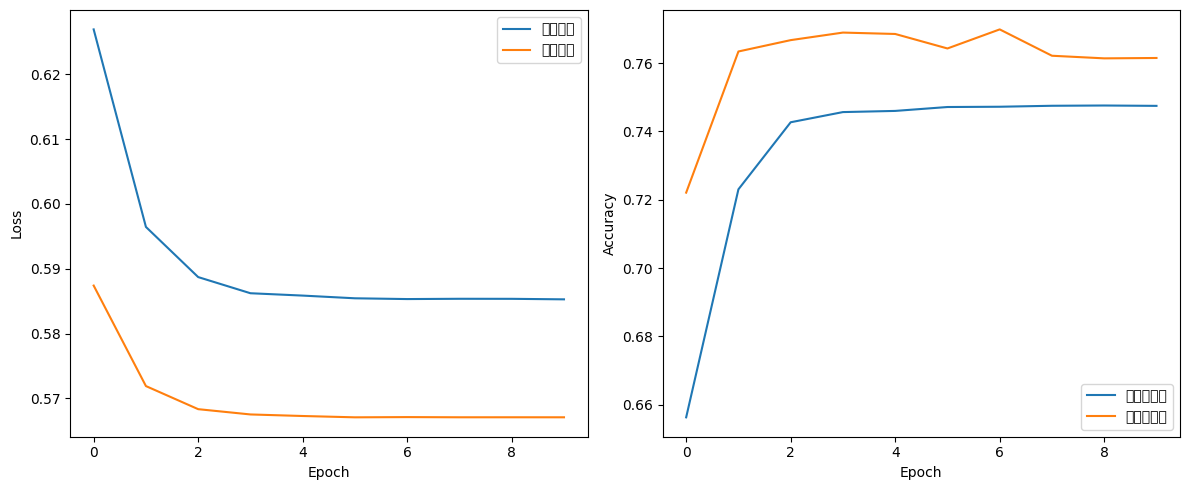

InvalidArgumentError: Graph execution error:

Detected at node 'model_9/gcn_conv_8/SparseTensorDenseMatMul/SparseTensorDenseMatMul' defined at (most recent call last):
    File "c:\Users\pm\anaconda3\envs\310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\pm\anaconda3\envs\310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\pm\anaconda3\envs\310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\pm\anaconda3\envs\310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\pm\anaconda3\envs\310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell
      result = self._run_cell(
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell
      result = runner(coro)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\pm\AppData\Local\Temp\ipykernel_18936\3744208996.py", line 269, in <module>
      final_entity_embeddings = embedding_model.predict([node_features, adj_tensor])
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\spektral\layers\convolutional\conv.py", line 100, in _inner_check_dtypes
      f"of the node features {x.dtype} and has been automatically cast to "
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\spektral\layers\convolutional\gcn_conv.py", line 101, in call
      output = ops.modal_dot(a, output)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\spektral\layers\ops\matmul.py", line 129, in modal_dot
      if a_ndim == b_ndim:
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\spektral\layers\ops\matmul.py", line 131, in modal_dot
      return dot(a, b)
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\spektral\layers\ops\matmul.py", line 33, in dot
      if a_ndim == 2:
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\spektral\layers\ops\matmul.py", line 34, in dot
      if a_is_sparse and not b_is_sparse:
    File "c:\Users\pm\anaconda3\envs\310\lib\site-packages\spektral\layers\ops\matmul.py", line 35, in dot
      return tf.sparse.sparse_dense_matmul(a, b)
Node: 'model_9/gcn_conv_8/SparseTensorDenseMatMul/SparseTensorDenseMatMul'
Cannot multiply A and B because inner dimension does not match: 500000 vs. 32.  Did you forget a transpose?  Dimensions of A: [32, 500000).  Dimensions of B: [32,32]
	 [[{{node model_9/gcn_conv_8/SparseTensorDenseMatMul/SparseTensorDenseMatMul}}]] [Op:__inference_predict_function_61107033]

In [ ]:
# 7. 准备训练和验证数据
print("\n准备训练和验证数据...")

# 修复generate_triplets函数，处理空输入的情况
def generate_triplets(heads, relations, tails, num_entities, negative_ratio=1):
    """
    输入正样本 (heads, relations, tails)，
    为每个正样本生成 negative_ratio 个负样本(随机替换头或尾)。
    返回 (all_heads, all_relations, all_tails, labels)
    """
    if len(heads) == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])
    labels = []
    samples = []
    
    for i in range(len(heads)):
        # 正样本
        samples.append([heads[i], relations[i], tails[i]])
        labels.append(1)  
        
        # 负样本
        for _ in range(negative_ratio):
            if np.random.random() < 0.5:
                # 换头
                fake_head = np.random.randint(0, num_entities)
                while fake_head == heads[i]:
                    fake_head = np.random.randint(0, num_entities)
                samples.append([fake_head, relations[i], tails[i]])
            else:
                # 换尾
                fake_tail = np.random.randint(0, num_entities)
                while fake_tail == tails[i]:
                    fake_tail = np.random.randint(0, num_entities)
                samples.append([heads[i], relations[i], fake_tail])
            labels.append(0)

    samples = np.array(samples)
    labels = np.array(labels)
    return samples[:, 0], samples[:, 1], samples[:, 2], labels

# 假设 edges_src, edges_dst, edge_types 是正样本
train_idx, valid_idx = train_test_split(
    range(len(edges_src)), test_size=0.1, random_state=42
)

train_edges_src = edges_src[train_idx]
train_edges_dst = edges_dst[train_idx]
train_edge_types = edge_types[train_idx]

valid_heads_orig = edges_src[valid_idx]
valid_tails_orig = edges_dst[valid_idx]
valid_relations_orig = edge_types[valid_idx]

# 生成训练数据
train_heads_all, train_relations_all, train_tails_all, train_labels = generate_triplets(
    train_edges_src, train_edge_types, train_edges_dst, num_entities, negative_ratio=1
)

print(f"训练集 样本数: {len(train_labels)} | 正样本: {np.sum(train_labels)} | 负样本: {len(train_labels) - np.sum(train_labels)}")

# 生成验证数据
valid_heads_all, valid_relations_all, valid_tails_all, valid_labels = generate_triplets(
    valid_heads_orig, valid_relations_orig, valid_tails_orig, num_entities, negative_ratio=1
)

print(f"验证集 样本数: {len(valid_labels)} | 正样本: {np.sum(valid_labels)} | 负样本: {len(valid_labels) - np.sum(valid_labels)}")

# ============================
# 3. 训练循环
# ============================

# 学习率衰减
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

# 准备指标
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
train_acc_metric = tf.keras.metrics.BinaryAccuracy(name='train_acc')

# 记录训练过程
history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

best_val_loss = float('inf')
best_epoch = 0
best_weights = None
no_improvement_count = 0

batch_size = 128
epochs = 100
patience = 5
min_delta = 0.001

print("\n开始训练...")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # 每轮重置
    train_loss_metric.reset_states()
    train_acc_metric.reset_states()
    
    # 打乱训练数据
    idx_shuffle = np.random.permutation(len(train_labels))
    train_heads_all_shuffled = train_heads_all[idx_shuffle]
    train_rels_all_shuffled = train_relations_all[idx_shuffle]
    train_tails_all_shuffled = train_tails_all[idx_shuffle]
    train_labels_shuffled = train_labels[idx_shuffle]
    
    num_batches = (len(train_labels_shuffled) + batch_size - 1) // batch_size

    # ---------- 训练循环 -----------
    for b in range(num_batches):
        start_idx = b * batch_size
        end_idx = min((b+1)*batch_size, len(train_labels_shuffled))

        batch_heads = train_heads_all_shuffled[start_idx:end_idx]
        batch_rels = train_rels_all_shuffled[start_idx:end_idx]
        batch_tails = train_tails_all_shuffled[start_idx:end_idx]
        batch_y = train_labels_shuffled[start_idx:end_idx]

        with tf.GradientTape() as tape:
            # 前向传播
            predictions = model([
                node_features,   # (N, F)
                adj_tensor,      # (N, N)
                batch_heads,     # (batch_size,)
                batch_rels,
                batch_tails
            ], training=True)
            # predictions.shape => (batch_size,)

            # 计算 loss
            loss = tf.keras.losses.binary_crossentropy(batch_y, predictions)
            loss = tf.reduce_mean(loss)
        
        # 更新梯度
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # 更新训练指标
        train_loss_metric.update_state(loss)
        # 注意：如果 predictions = (batch_size,), batch_y=(batch_size,),
        # 那么两者可直接对齐
        train_acc_metric.update_state(batch_y, predictions)

        # 打印批次进度
        print(f"\rBatch {b+1}/{num_batches} - "
              f"loss: {train_loss_metric.result():.4f} - "
              f"acc: {train_acc_metric.result():.4f}", end="")
    # end for b in range(num_batches)

    # ============ 验证集评估 ============
    valid_loss_total = 0
    valid_acc_total = 0
    valid_len = len(valid_labels)
    
    valid_batch_size = 512
    valid_num_batches = (valid_len + valid_batch_size - 1) // valid_batch_size
    
    for vb in range(valid_num_batches):
        vstart = vb * valid_batch_size
        vend = min((vb+1)*valid_batch_size, valid_len)
        
        batch_heads = valid_heads_all[vstart:vend]
        batch_rels  = valid_relations_all[vstart:vend]
        batch_tails = valid_tails_all[vstart:vend]
        batch_y     = valid_labels[vstart:vend]

        val_preds = model([
            node_features,
            adj_tensor,
            batch_heads,
            batch_rels,
            batch_tails
        ], training=False)

        b_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(batch_y, val_preds))
        # 计算批次准确率
        # 注意 val_preds, batch_y 均为 (batch_size,)
        b_acc = tf.reduce_mean(
            tf.cast(tf.equal(tf.round(val_preds), batch_y), tf.float32)
        )

        batch_size_current = vend - vstart
        valid_loss_total += b_loss.numpy() * batch_size_current
        valid_acc_total  += b_acc.numpy() * batch_size_current
    
    valid_loss = valid_loss_total / valid_len
    valid_acc  = valid_acc_total / valid_len
    
    # 记录到 history
    train_loss_value = train_loss_metric.result().numpy()
    train_acc_value  = train_acc_metric.result().numpy()
    
    history['loss'].append(train_loss_value)
    history['accuracy'].append(train_acc_value)
    history['val_loss'].append(valid_loss)
    history['val_accuracy'].append(valid_acc)

    # 输出本轮结果
    print(f"\rEpoch {epoch+1}/{epochs} - "
          f"loss: {train_loss_value:.4f} - acc: {train_acc_value:.4f} - "
          f"val_loss: {valid_loss:.4f} - val_acc: {valid_acc:.4f}")
    
    # ============ 早停判定 ============
    if valid_loss < best_val_loss - min_delta:
        best_val_loss = valid_loss
        best_epoch = epoch
        best_weights = model.get_weights()
        no_improvement_count = 0
        print(f"  ✓ 新的最佳模型! (val_loss: {best_val_loss:.4f})")
    else:
        no_improvement_count += 1
        print(f"  ✗ 验证损失未改善 ({no_improvement_count}/{patience})")
    
    if no_improvement_count >= patience:
        print(f"\n早停! 在 {patience} 个 epoch 内验证损失未改善。")
        print(f"回到 epoch={best_epoch+1} 权重 (val_loss={best_val_loss:.4f})")
        model.set_weights(best_weights)
        break

# ============ 恢复最佳权重 ============
if best_weights is not None:
    model.set_weights(best_weights)
    print(f"使用最佳权重 (来自 epoch {best_epoch+1}, val_loss={best_val_loss:.4f})")

# ============================
# 4. 保存模型 & 可视化
# ============================
MODEL_DIR = "./saved_model"
os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, "best_kg_model")
model.save_weights(model_path)
print(f"模型权重已保存: {model_path}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='训练损失')
plt.plot(history['val_loss'], label='验证损失')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='训练准确率')
plt.plot(history['val_accuracy'], label='验证准确率')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'))
plt.show()



In [ ]:
print("node_features.shape =", node_features.shape)
if isinstance(adj_tensor, tf.sparse.SparseTensor):
    print("adj_tensor.dense_shape =", adj_tensor.dense_shape.numpy())
else:
    print("adj_tensor.shape =", adj_tensor.shape)

# ============ 提取最终实体嵌入（可选） ============
# 单图模式下，embedding_model 直接输入 (N,F) + (N,N)
# 就能得到 (N, hidden_dim)
final_entity_embeddings = embedding_model([
    node_features,         # shape (N, F)
    adj_tensor             # shape (N, N)
], training=False)
# final_entity_embeddings = embedding_model.predict_on_batch([
#     node_features,
#     adj_tensor
# ])
print("final_entity_embeddings.shape =", final_entity_embeddings.shape)

node_features.shape = (500000, 32)
adj_tensor.dense_shape = [500000 500000]
final_entity_embeddings.shape = (500000, 32)
final_entity_embeddings.shape = (500000, 32)


保存模型


保存模型和映射数据...
映射数据保存到: ./saved_model\kg_mappings.pkl
训练历史图保存到: ./saved_model\training_history.png

训练完成!


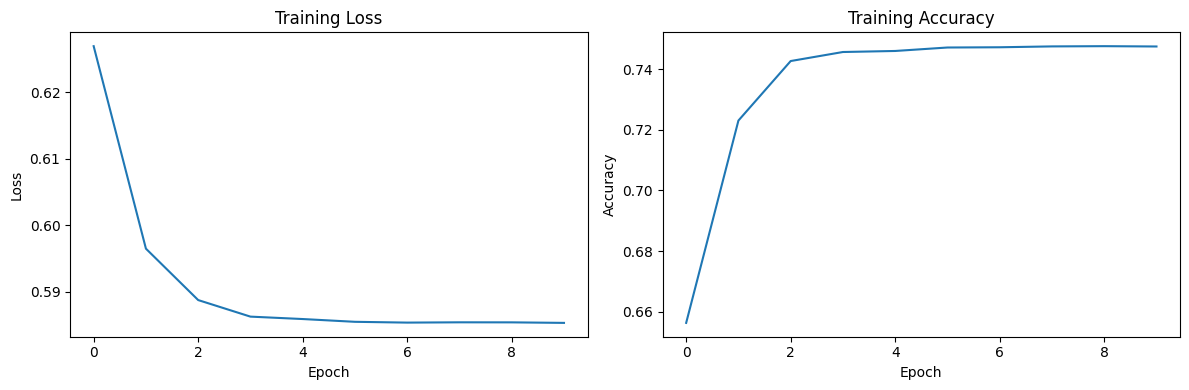

In [26]:
# 9. 保存模型
print("\n保存模型和映射数据...")
model.save_weights(os.path.join(MODEL_DIR, "rgcn_model_weights"))

# 保存编码器和别名映射
mapping_path = os.path.join(MODEL_DIR, "kg_mappings.pkl")
with open(mapping_path, 'wb') as f:
    pickle.dump({
        'entity_encoder': entity_encoder,
        'relation_encoder': relation_encoder,
        'entity_id_to_aliases': entity_id_to_aliases,
        'entity_alias_to_id': entity_alias_to_id,
        'relation_id_to_aliases': relation_id_to_aliases,
        'relation_alias_to_id': relation_alias_to_id
    }, f)
print(f"映射数据保存到: {mapping_path}")

# 10. 绘制训练历史
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'))
print(f"训练历史图保存到: {os.path.join(MODEL_DIR, 'training_history.png')}")

print("\n训练完成!")